# Data Wrangling

In [48]:
# all modules

import warnings
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
from functools import reduce

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
import missingno as msno

In [10]:
# global stuff

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_rows', 13)
pd.set_option('display.max_columns', 13)

In [11]:
def get_dictEuropeanCountries():
    wiki_url= 'https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2'
    url= 'https://www.euro.who.int/en/countries'
    
    html_wikipage = requests.get(wiki_url).content
    html_eurocountries = requests.get(url).content
        
    countries_list = pd.read_html(html_wikipage, header=0)[2]
    countries_dict = dict(zip(countries_list['Code'], countries_list['Country name (using title case)']))

    soup = BeautifulSoup(html_eurocountries, 'lxml')
    table = soup.find_all('section', {'class':'clearfix'})

    all_contries = [content.text for content in table]
    eu_countries = list(filter(None, all_contries[0].split('\n')))

    european_countries_values = [val for k,val in countries_dict.items() for eu_c in eu_countries if val == eu_c]
    european_countries_key = [k for k,val in countries_dict.items() for eu_c in eu_countries if val == eu_c]

    return dict(zip(european_countries_key, european_countries_values))

## OPENING CLEANED TABLES

In [12]:
df_personal_info = pd.read_csv('../data/processed/personal_info.csv', index_col=[0])
df_career_info = pd.read_csv('../data/processed/career_info.csv', index_col=[0])
df_country_info = pd.read_csv('../data/processed/country_info.csv', index_col=[0])

In [13]:
df_career_info.head()

,uuid,dem_full_time_job,normalized_job_code,High_Ed,Low_Ed,Medium_Ed,No_Ed,Unknown_Ed,normalized_job_names
0,f6e7ee00-deac-0133-4de8-0a81e8b09a82,False,NaN,False,False,False,True,False,NaN
1,54f0f1c0-dda1-0133-a559-0a81e8b09a82,True,861a9b9151e11362eb3c77ca914172d0,True,False,False,False,False,Automatic Data Processing Planner
2,83127080-da3d-0133-c74f-0a81e8b09a82,False,NaN,False,False,False,False,True,NaN
3,15626d40-db13-0133-ea5c-0a81e8b09a82,True,049a3f3a2b5f85cb2971ba77ad66e10c,True,False,False,False,False,Data Coordinator
4,24954a70-db98-0133-4a64-0a81e8b09a82,True,f4b2fb1aa40f661488e2782b6d57ad2f,True,False,False,False,False,Database Developer


# TABLE 1 [country-job title-gender-quantity-percetnage]

In [6]:
########## FUNCTIONS TO EVAL ARGUMENT AT THE BEGINNING

def country_argparse_eval(country_argument, list_to_search):
    """
    Evaluates whether argument exists in df_country_info[country_names]
    """
    print(f'\t ··· Validating country argparse')
    
    if country_argument in list_to_search:
        print(f'\t\t >> country_argument found in ddbb')
        def_country_argument = country_argument
        return def_country_argument
    
    else:
        print(f'\t\t >> country_argument not found')
        def_country_argument = ""
        return def_country_argument

    
def country_argparse_filter(country_argument, analysis_df):
    """
    Return analysis df by argument input
    """
    list_to_search = analysis_df['country_names'].unique().tolist()
    c_arg = country_argparse_eval(country_argument, list_to_search)
    
    if c_arg == "":
        return analysis_df
    else:
        return analysis_df[analysis_df['country_names'] == c_arg]

    
def get_base_analysis_df(country_argument):
    """
    Returns base_df for analysis after evaluating country argument
    """
    dfs = [
        df_country_info[['uuid', 'country_names']],
        df_personal_info[['uuid', 'gender']],
        df_career_info[['uuid', 'normalized_job_names', 'dem_full_time_job', 'High_Ed', 'Low_Ed', 'Medium_Ed', 'No_Ed']], 
        ]

    df_final = reduce(lambda left,right: pd.merge(left,right,on='uuid'), dfs)
    
    return country_argparse_filter(country_argument.capitalize(), df_final)

In [7]:
def get_percentages_gender_by_job(base_analysis_df):
    
    # Variables.
    filtr = ['country_names','normalized_job_names','gender']
    
    drop_cols = ['uuid', 'dem_full_time_job', 
                 'High_Ed', 'Low_Ed', 'Medium_Ed', 'No_Ed', 
                 'totals_per_country']
    
    new_cols = ['quantity', 'percentage']

    # Add first col = quality
    df_job_gender = base_analysis_df.assign(quantity = 1)\
                         .drop(columns=drop_cols[0:-1])\
                         .groupby(filtr)\
                         .agg('count')\
                         .reset_index()
    
    # Generate totals_per_country
    df_total_per_country = df_job_gender.groupby(filtr[0])\
                        [filtr[1]]\
                        .nunique()\
                        .to_frame()\
                        .rename(columns={filtr[1]: drop_cols[-1]})
    
    df_job_gender = df_job_gender.merge(df_total_per_country, on=filtr[0])

    # Add second col == percentage and deleting totals_per_country when not need
    df_job_gender[new_cols[1]] = round(df_job_gender[new_cols[0]] / df_job_gender[drop_cols[-1]] * 100, 3)
    df_job_gender.drop(columns=[drop_cols[-1]], inplace=True)
    
    return df_job_gender
    

In [8]:
df_job_gender = get_percentages_gender_by_job(
                get_base_analysis_df(country_argument='SpAiN'))

	 ··· Validating country argparse
		 >> country_argument found in ddbb


In [9]:
df_job_gender

,country_names,normalized_job_names,gender,quantity,percentage
0,Spain,Analytical Data Miner,M,1,0.781
1,Spain,Automatic Data Processing Customer Liaison (AD...,F,5,3.906
2,Spain,Automatic Data Processing Customer Liaison (AD...,M,6,4.688
3,Spain,Automatic Data Processing Planner,F,5,3.906
4,Spain,Automatic Data Processing Planner,M,4,3.125
...,...,...,...,...,...
203,Spain,Survey Data Technician,F,1,0.781
204,Spain,Voice and Data Technician,F,1,0.781
205,Spain,Voice and Data Technician,M,1,0.781
206,Spain,Weight in Motion Field Data Collection Technician,F,2,1.562


# TABLE 3 [top 10 skills by education level]

In [10]:
df_analysis = get_base_analysis_df(country_argument='SpAiN')

	 ··· Validating country argparse
		 >> country_argument found in ddbb


In [11]:
df_high_ed = df_analysis[df_analysis['High_Ed']].drop(columns=['High_Ed', 'Low_Ed', 'Medium_Ed', 'No_Ed'])

In [12]:
df_high_ed[df_high_ed['gender'] == 'F'].head(3)
df_high_ed[df_high_ed['gender'] == 'M'].head(3)

,uuid,country_names,gender,normalized_job_names,dem_full_time_job
2212,72a48100-da38-0133-487f-0a81e8b09a82,Spain,M,Clinical Data Management Manager (CDM Manager),True
2218,6256a6a0-d961-0133-7e9a-0a81e8b09a82,Spain,M,NaN,False
2225,33a4bd30-d97d-0133-0b6d-0a81e8b09a82,Spain,M,Automatic Data Processing Planner,True


In [122]:
def top_skills_by_ed_level(base_analysis_df, number_skills, ed_level, gender_to_eval):
    
    
    # Variables
    filtr = 'normalized_job_names'
    drop_cols = ['uuid', 'country_names', 'gender', 'dem_full_time_job']
    
    # Filter by education level
    df_high_ed = base_analysis_df[df_analysis[ed_level]]\
                                .drop(columns=['High_Ed', 'Low_Ed', 'Medium_Ed', 'No_Ed'])
    # Getting only one gender
    if gender_to_eval == "All":
        df_high_ed
    else:        
        df_high_ed = df_high_ed[df_high_ed['gender'] == gender_to_eval]
    
    # Counting and sorting
    df_high_ed_skills_gender = df_high_ed.assign(counts = 1)\
                                     .drop(columns=drop_cols)\
                                     .groupby(filtr)\
                                     .agg('count')\
                                     .reset_index()

    df_high_ed_skills_gender.sort_values(by=['counts'], ascending=False, inplace=True)
    counts_by_gender = df_high_ed_skills_gender['counts'].tolist()
    
    pd = df_high_ed_skills_gender[filtr].reset_index().head(number_skills)
                                  
    pd = pd.rename(columns={filtr: ed_level}).drop(columns='index')
    counts_by_gender = counts_by_gender[:number_skills]
    
    # returns tuple 
    return pd, counts_by_gender

In [123]:
serie_top_skills_high_ed = top_skills_by_ed_level(base_analysis_df= get_base_analysis_df(
                                                                country_argument= 'Spain'), 
                                              number_skills= 5, 
                                              ed_level= 'Low_Ed',
                                              gender_to_eval= 'F')

	 ··· Validating country argparse
		 >> country_argument found in ddbb


In [124]:
serie_top_skills_high_ed[1]

[2, 1, 1, 1, 1]

In [211]:
def get_df_top_skills(country_argument, num_top_skills, list_dfs_cleaned, gender="All"):
    # Variables
    ed_levels = ['High_Ed', 'Medium_Ed', 'Low_Ed']
    path_to_save = 'data/results'

    # Tuples of top skills jobs and counters
    serie_top_skills_high_ed, counts_top_skills_high_ed = top_skills_by_ed_level(base_analysis_df=get_base_analysis_df(country_argument=country_argument, list_of_clean_df= list_dfs_cleaned),
                                                                                number_skills=num_top_skills,
                                                                                ed_level=ed_levels[0],
                                                                                gender_to_eval= gender)

    serie_top_skills_medium_ed, counts_top_skills_medium_ed = top_skills_by_ed_level(base_analysis_df=get_base_analysis_df(country_argument=country_argument, list_of_clean_df= list_dfs_cleaned),
                                                                                number_skills=num_top_skills,
                                                                                ed_level=ed_levels[1],
                                                                                gender_to_eval=gender)

    serie_top_skills_low_ed, counts_top_skills_low_ed = top_skills_by_ed_level(base_analysis_df=get_base_analysis_df(country_argument=country_argument, list_of_clean_df= list_dfs_cleaned),
                                                                                number_skills=num_top_skills,
                                                                                ed_level=ed_levels[2],
                                                                                gender_to_eval=gender)

    cols = dict(zip([n for n in range(5)], ['#' + str(n) for n in range(5)]))
    # Construccion of DF of jobs
    all_dfs = [serie_top_skills_high_ed, serie_top_skills_medium_ed, serie_top_skills_low_ed]
    result_dfs = pd.concat(all_dfs, axis=1, sort=False)

    df_to_save = result_dfs.T.rename(columns=cols)

    # Construction of DF of counts
    all_counts = [counts_top_skills_high_ed, counts_top_skills_medium_ed, counts_top_skills_low_ed]
    result_counts = pd.DataFrame(all_counts)

    # Save DataFrame to csv in data/results
    m_ac.save_df_to_csv(df_to_save,
                        path=path_to_save,  # Function adds hierarchy of files
                        name=f'df_top_skills')  # Name of csv
    return df_to_save, result_counts, gender

In [212]:
df_top_skills_M = get_df_top_skills(country_argument = 'Spain', 
                                  num_top_skills = 5)

TypeError: get_df_top_skills() missing 1 required positional argument: 'list_dfs_cleaned'

In [207]:
df_top_skills[0].shape

(3, 5)

In [156]:
counts_3

[8, 5, 2]

In [208]:
def get_stacked_bar_plot(tuple_top_skills):

    # Variables
    gender = tuple_top_skills[2]
    file_name = f'visualizacion_{gender}_distribution_top_skills'
    N = tuple_top_skills[0].shape[1] # shape is [5x3]
    ind = np.arange(N)    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

    # list of values
    counts_1 = list(tuple_top_skills[1].iloc[:, 0])
    counts_2 = list(tuple_top_skills[1].iloc[:, 1])
    counts_3 = list(tuple_top_skills[1].iloc[:, 2])
    counts_4 = list(tuple_top_skills[1].iloc[:, 3])
    counts_5 = list(tuple_top_skills[1].iloc[:, 4])

    # stack_bars
    top_1 = plt.bar(ind, counts_1, width, bottom= 0, color='darkcyan')
    top_2 = plt.bar(ind, counts_2, width, bottom= counts_1, color='cadetblue')
    top_3 = plt.bar(ind, counts_3, width, bottom= [i+j for i,j in zip(counts_1, counts_2)], color='cyan')
    top_4 = plt.bar(ind, counts_4, width, bottom= [i+j+k for i,j,k in zip(counts_1, counts_2, counts_3)], color='lightseagreen')
    top_5 = plt.bar(ind, counts_5, width, bottom= [i+j+k+l for i,j,k,l in zip(counts_1, counts_2, counts_3, counts_4)], color='lightskyblue')

    plt.ylim(0, 45)
    # Legend for X and Y
    plt.title(f'VARIATION OF TOP SKILLS BY EDUCATION. GENDER = {gender}')
    plt.xticks(ind, ('high_ed', 'medium_ed', 'low_ed'))
    plt.legend((top_1[0], top_2[0], top_3[0], top_4[0], top_5[0]), ('#1', '#2', '#3', '#4', '#5'))

    #Save to data/results
    fig = plt.gcf()
    fig.set_size_inches(12, 20)
    fig.savefig(f'../data/results/{file_name}.png', dpi=100)

    return plt.show()


In [210]:
stacked_bar_plot(get_df_top_skills(country_argument = 'Spain', 
                                  num_top_skills = 5,
                                  gender = 'M'))

	 ··· Validating country argparse
		 >> country_argument found in ddbb
	 ··· Validating country argparse
		 >> country_argument found in ddbb
	 ··· Validating country argparse
		 >> country_argument found in ddbb


TypeError: stacked_bar_plot() missing 1 required positional argument: 'gender'

In [106]:
[-1*i for i in list(df_top_skills_F[1].iloc[0,:])]

[-5, -5, -4, -4, -4]

In [105]:
[-1*i for i in list(df_top_skills_F[1].iloc[1,:])]

[-4, -3, -3, -3, -3]

In [ ]:
    # list of values
    count_str = 'counts_'
    dict_names =  []
    for n in Number_of_stacks:
        dict_names.append
    counts_1 = list(tuple_top_skills[1].iloc[:, 0])
    counts_2 = list(tuple_top_skills[1].iloc[:, 1])
    counts_3 = list(tuple_top_skills[1].iloc[:, 2])
    counts_4 = list(tuple_top_skills[1].iloc[:, 3])
    counts_5 = list(tuple_top_skills[1].iloc[:, 4])


In [220]:
dict_names =  []
dict_lists =  []

for n in range(5):
    dict_names.append(f'count_{n}')
    dict_lists.append(list(df_top_skills_F[1].iloc[:, n]))
                      
dict_counts = dict(zip(dict_names, dict_lists)) 

In [221]:
dict_counts

{'count_0': [5, 4, 2],
 'count_1': [5, 3, 1],
 'count_2': [4, 3, 1],
 'count_3': [4, 3, 1],
 'count_4': [4, 3, 1]}

In [222]:
dict_counts['count_0']

[5, 4, 2]

## SACAR ALGO DE POLLS

In [5]:
df_poll_basicincome_argumentsagainst= pd.read_csv('../data/processed/poll_basicincome_argumentsagainst.csv', index_col=[0])

In [35]:
df_poll_basicincome_argumentsagainst.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9649 entries, 0 to 9648
Data columns (total 7 columns):
 #   Column                                                                 Non-Null Count  Dtype
---  ------                                                                 --------------  -----
 0   None of the above                                                      9649 non-null   bool 
 1   Only the people who need it most should get something from the state   9649 non-null   bool 
 2   It might encourage people to stop working                              9649 non-null   bool 
 3   It is against the principle of linking merit and reward                9649 non-null   bool 
 4   Foreigners might come to my country and take advantage of the benefit  9649 non-null   bool 
 5   It is impossible to finance                                            9649 non-null   bool 
 6   It increases dependence on the state                                   9649 non-null   bool 
dtypes: bool

In [14]:
df_personal_info.head()

,uuid,age,gender,dem_has_children,age_group,gender_Female,gender_Male,ageGroup_14_25,ageGroup_26_39,ageGroup_40_65,ageGroup_juvenile
0,f6e7ee00-deac-0133-4de8-0a81e8b09a82,61,M,False,40_65,False,True,False,False,True,False
1,54f0f1c0-dda1-0133-a559-0a81e8b09a82,57,M,True,40_65,False,True,False,False,True,False
2,83127080-da3d-0133-c74f-0a81e8b09a82,32,M,False,26_39,False,True,False,True,False,False
3,15626d40-db13-0133-ea5c-0a81e8b09a82,45,M,True,40_65,False,True,False,False,True,False
4,24954a70-db98-0133-4a64-0a81e8b09a82,41,F,True,40_65,True,False,False,False,True,False


In [148]:
cols = list(df_poll_basicincome_argumentsagainst.columns)
gender = list(df_personal_info['gender'].unique())

df_joined= df_personal_info[['uuid','gender']]\
                            .join(df_poll_basicincome_argumentsagainst, on=None, how='left', sort=False)

In [189]:
df_filtered.head(5)

,uuid,gender,None of the above,Only the people who need it most should get something from the state,It might encourage people to stop working,It is against the principle of linking merit and reward,Foreigners might come to my country and take advantage of the benefit,It is impossible to finance,It increases dependence on the state
0,f6e7ee00-deac-0133-4de8-0a81e8b09a82,M,True,False,False,False,False,False,False
1,54f0f1c0-dda1-0133-a559-0a81e8b09a82,M,False,False,True,False,False,False,False
2,83127080-da3d-0133-c74f-0a81e8b09a82,M,False,False,False,False,True,False,False
3,15626d40-db13-0133-ea5c-0a81e8b09a82,M,True,False,False,False,False,False,False
7,dd743bb0-d9a5-0133-53b2-0a81e8b09a82,M,False,True,True,False,True,True,False


In [149]:
df_filtered = df_joined[df_joined['gender'] == 'M']

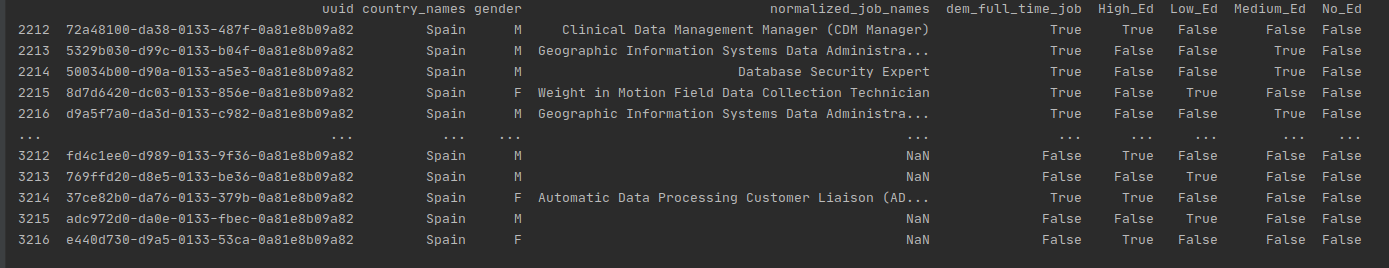

In [157]:
#### this is gold
list_of_lists = []

for gender_name in gender:
    print(gender_name)
    
    list_of_bars = []

    for i in range(len(cols)):
        list_of_bars.append(df_joined[df_joined['gender'] == gender_name][cols[i]].value_counts())
        
    list_of_trues = [list_of_bars[i].iloc[1] for i in range(len(list_of_bars))]
    print(list_of_trues)
    list_of_lists.append(list_of_trues)


M
[707, 1589, 2222, 1181, 1789, 1628, 1273]
F
[674, 1518, 2010, 901, 1552, 1590, 1121]


In [158]:
def get_df_poll_filtered_by_gender(list_separated_polls, poll_to_extract):
    """
    INPUT  ->  [poll_1, poll_2, poll_3, poll_4] + 'poll_3'    -> data cleaned as extracted
    OUTPUT ->  in poll_3, list of trues responses by gender   -> data for visualization
    """
    possible_cols = ['question_bbi_2016wave4_basicincome_awareness',
                    'question_bbi_2016wave4_basicincome_effect',
                    'question_bbi_2016wave4_basicincome_vote',
                    'question_bbi_2016wave4_basicincome_argumentsagainst',
                    'question_bbi_2016wave4_basicincome_argumentsfor']
    try:
        if poll_to_extract in possible_cols:
            df_poll = list_separated_polls[poll_to_extract]

            # important columns
            cols_poll = list(df_poll_basicincome_argumentsagainst.columns)
            gender = list(df_personal_info['gender'].unique())
            
            #
            df_joined= base_analysis_df[['uuid','gender']]\
                                        .join(df_poll_basicincome_argumentsagainst, on=None, how='left', sort=False)

            # getting data for visualiza
            list_of_lists = []

            for gender_name in gender:
                list_of_counts = []

                for i in range(len(cols)):
                    list_of_counts.append(df_joined[df_joined['gender'] == gender_name][cols_poll[i]].value_counts())

                list_of_trues = [list_of_bars[i].iloc[1] for i in range(len(list_of_bars))]
                list_of_lists.append(list_of_trues)

            return list_of_lists #[[M trues], [F trues]]

        else:
            raise ColumnMissing
            
    except ColumnMissing:
        print('The entry [poll_to_extract] is not correct')

AttributeError: module 'matplotlib.pyplot' has no attribute 'spines'

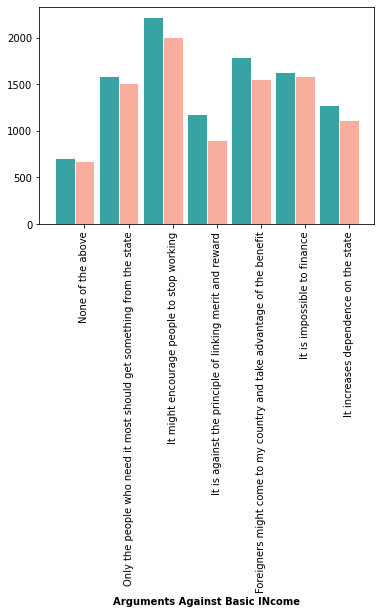

In [188]:
def stacked_bar_graph(bars_lists):
    # set width of bar
    barWidth = 0.45

    # set height of bar
    bars1 = list_of_lists[0]
    bars2 = list_of_lists[1]

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]

    # Make the plot
    plt.bar(r1, bars1, color='#38a3a5', width=barWidth, edgecolor='white', label='var1')
    plt.bar(r2, bars2, color='#f8ad9d', width=barWidth, edgecolor='white', label='var2')

    # Add xticks on the middle of the group bars
    plt.xlabel('Arguments Against Basic INcome', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars1))], cols)
    plt.xticks(rotation=90)

    plt.legend(gender)
    plt.show()
